In [1]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy.linalg as la
import sys, os
import pickle
import geopandas
#import rbf as RBF
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
%load_ext cython

In [2]:
from FME.geological_points import IePoint, IPoint, GPoint, TPoint
from FME.geological_interpolator import GeologicalInterpolator
from FME.tet_mesh import TetMesh
from FME.dsi_interpolator import DSI
from FME.foldframe import FoldFrame
from FME.fold import FoldEvent, DSIFoldConstraint
#from FME.structural_frame import StructuralFrame
from FME.fault_segment import FaultSegment
from FME.region_manager import RegionManager
from FME.helper import *
from FME.svariogram import s_variogram#

In [3]:
orientations = geopandas.read_file('./shapefiles/orientations.shp')
lines = geopandas.read_file('./shapefiles/lines.shp')
points = geopandas.read_file('./shapefiles/points.shp')
model_area = geopandas.read_file('./shapefiles/big_box.shp')
geom = model_area.iloc[0]['geometry']
coords = np.array(geom.exterior.coords[:])
minz = -(np.max(coords[:,0])-np.min(coords[:,0]))/2.
# geom = model_area.shapes()
print(minz)


-8559.688807213679


In [4]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = np.min(coords[:,0])
boundary_points[0,1] = np.min(coords[:,1])
boundary_points[0,2] = minz
boundary_points[1,0] = np.max(coords[:,0])
boundary_points[1,1] = np.max(coords[:,1])
boundary_points[1,2] = -minz*0.1
mesh = TetMesh('FaultedFold',)
mesh.setup_mesh(boundary_points,nstep=1,n_tetra=50000,)
regionmanager = RegionManager(mesh)
xrange = boundary_points[1,0] - boundary_points[0,0]
yrange = boundary_points[1,1] - boundary_points[0,1]
zrange = boundary_points[1,2] - boundary_points[0,2]
r1 = np.array(boundary_points,copy=True)
r1[0,0] += xrange*.05
r1[1,0] -= xrange*.05
r1[0,1] += yrange*.05
r1[1,1] -= yrange*.05
r1[0,2] += zrange*.05
r1[1,2] -= zrange*.05

regionmanager.create_region_from_boundary_box(r1,'r1')

#mesh.regions['R1'] = np.logical_and(mesh.nodes[:,0]>boundary_points[0,0]*.8,mesh.nodes[:,0]<boundary_points[1,0]*.8)
# mesh.regions['R1']= np.logical_and(mesh.regions['R1'],mesh.nodes[:,1]>boundary_points[0,1]*.8) #ymin
# mesh.regions['R1']= np.logical_and(mesh.regions['R1'],mesh.nodes[:,1]<boundary_points[1,1]*.8)
# mesh.regions['R1']= np.logical_and(mesh.regions['R1'],mesh.nodes[:,2]>boundary_points[0,2]*.8)
# mesh.regions['R1']= np.logical_and(mesh.regions['R1'],mesh.nodes[:,2]<boundary_points[1,2]*.8)
#print(mesh.regions['R1'])
#regionmanager.create_region_from_boundary_box(boundary_points*.8,'r1')
regionmanager.create_properties_for_regions()
cg = mesh.get_constant_gradient(region=mesh.regions['everywhere'],shape='square')
# # second mesh is for the model area and the points can be moved around. No interpolation \
# # is performed on this mesh its just here because paraview can contour mesh objects not voxets
# boundary_points2 = np.zeros((2,3))
# boundary_points2=boundary_points*0.6
# mesh2 = TetMesh('Flower3DModel')
# mesh2.setup_mesh(boundary_points2,maxvol=0.5)
mesh.save()
print(mesh.n_nodes)

10694


In [7]:
print(orientations)

print(points)

print(lines)

  type  strike  dip itype                                     geometry
0   s2      90   90    gx  POINT (378919.6721233819 5789822.379812676)
1   s2       0   90    gy  POINT (379502.5872370945 5789258.828824564)
2   f1     190   60    gx   POINT (378577.510662704 5787831.658145825)
   value type itype     z                                     geometry
0   -1.0   s1    gx   0.0   POINT (378828.4866120323 5782318.51413778)
1    1.0   s1    gx   0.0  POINT (379520.0583151031 5794948.989060227)
2   -1.0   s1    gy   0.0  POINT (372634.8291044158 5789693.044853563)
3    1.0   s1    gy   0.0  POINT (388459.5948601614 5789184.270505347)
4   -1.0   f1    gy   0.0   POINT (378245.6982135118 5786246.74714883)
5    1.0   f1    gy -10.0  POINT (379350.2259409281 5789778.809217884)
6   -1.0   f1    gz   0.0  POINT (380720.3542450377 5794524.086167265)
7    1.0   f1    gz   0.0   POINT (376941.4425829074 5782481.06340295)
  type                                           geometry
0   f1  LINESTRING 

In [8]:
f2 = FoldFrame(mesh=mesh,region='everywhere',shape='square',name='F1')

for i, r in orientations.iterrows():
    if r['type'] == 's1':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        f2.add_strike_and_dip([xy[0][0],xy[1][0],z],r['strike'],r['dip'],itype=r['itype'])
for i, r in points.iterrows():
    if r['type'] == 's1':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        f2.add_point([xy[0][0],xy[1][0],z],r['value'],itype=r['itype'])
for i, r in lines.iterrows():
    if r['type'] == 's1':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        f2.add_point([xy[0][0],xy[1][0],z],r['value'],itype='gx')        
        
# for r,l in lines:
#     if l.record[0] == 's1':
#         for p in l.shape.points:
#             f2.add_point([p[0],p[1],0],0,itype='gx')
# for o in orientations:
#     if o.record[0] == 's1':
#         p = o.shape.points[0]
#         f2.add_strike_and_dip([p[0],p[1],0.],o.record[1],o.record[2],itype=o.record[3])
# for p in points:
#     if p.record[1]  == 's1':
#         f2.add_point([p.shape.points[0][0],p.shape.points[0][1],p.record[3]],float(p.record[0]),itype=p.record[2])
f2.buildFrame(solver='lu')
f2.interpolators['gx'].export_data_to_vtk('fold_f2_gx_data')

# s2.setup_interpolator()
# s2.solve_system(solver='chol')
# mesh.update_property('s2',s2.c)

Setting up interpolator with 2 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000
Setting up interpolator with 2 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000000


In [9]:
def fold_axis_rotation(x):
    r =  np.zeros(x.shape)
    r[:] = 0.
    return r#np.rad2deg(np.arctan(np.sin(x*100)))
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(np.sin(x*2)))

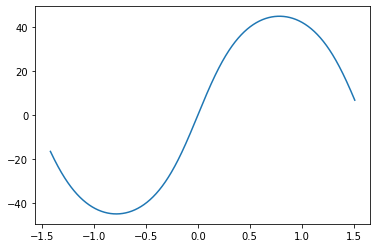

In [10]:
xi = np.linspace(np.min(mesh.properties['F1_gx']),np.max(mesh.properties['F1_gx']),1000)
plt.plot(xi,fold_limb_rotation(xi))
#plt.plot(s2,rotation,'bo')

In [11]:
fold = FoldEvent(f2,fold_axis_rotation,fold_limb_rotation)
const = DSIFoldConstraint(fold,mesh,shape='square')
const.use_deformed_orientation_cnstrt(5.)
const.use_fold_axis_cnstrt(3.)
const.use_regularisation_cnstrt(10.)
const.use_normalisation_cnstrt()

A, B, row, col = const.get_constraints()
deformed_orientation, fold_axis, dgz = fold.get_deformed_orientation(mesh.barycentre)
mesh.property_gradients['fold'] = deformed_orientation
mesh.property_gradients['axis'] = fold_axis
mesh.update_property('foldrot',fold_limb_rotation(mesh.properties['F1_gx']))

In [13]:
stratigraphy = DSI(mesh,region='everywhere',shape='square',solver='chol')
# for i in range(-15,15):
#     for j in range(-10,10):
#         stratigraphy.add_point([i,j,3*np.sin(j/5)],0.)
#         stratigraphy.add_point([i,j,3*np.sin(j/5)+1],1.)
stratigraphy.add_point(mesh.pca.inverse_transform([0.1,0.1,1.1]),0.)
# stratigraphy.add_point([80.1,0.1,1.1],1.)


stratigraphy.setup_interpolator(cg=False,cgw=0.)
stratigraphy.A.extend(A)
stratigraphy.row.extend(row)
stratigraphy.col.extend(col)
stratigraphy.B+=B
stratigraphy.solve_system(solver='lu',clear=True)
mesh.update_property('strati',stratigraphy.c)

Setting up interpolator with 1 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000000


In [10]:
gx=True
gy=True
gz=True
cgw = 100
cgw = cgw / mesh.n_elements
fault1 = FaultSegment(mesh=mesh,region='everywhere',shape='square',name='Fault1')
for l in lines:
    if l.record[0] == 'f1':
        for p in l.shape.points:
            fault1.add_point([p[0],p[1],0],0,itype='gx')
for o in orientations:
    print(o.record)
    if o.record[0] == 'f1':
        p = o.shape.points[0]
        fault1.add_strike_and_dip([p[0],p[1],0.],o.record[1],o.record[2],itype=o.record[3])
for p in points:
    print(p.record)
    if p.record[1]  == 'f1':
        fault1.add_point([p.shape.points[0][0],p.shape.points[0][1],p.record[3]],float(p.record[0]),itype=p.record[2])
fault1.buildFrame(solver='chol',
                   gxxgy=0.1,
                   gxxgz=1,
                   gyxgz=0.05,
                   gxcg=cgw,
                   gycg=cgw,
                   gzcg=cgw,
                   shape='square',
                   gxgcp=10,
                   gx=gx,
                   gy=gy,
                   gz=gz
                  )
fault1.interpolators['gx'].export_data_to_vtk('fault_f1_gx_data')

Record #0: ['s2', 90, 90, 'gx']
Record #1: ['s2', 0, 90, 'gy']
Record #2: ['f1', 190, 60, 'gx']
Record #0: [-1.0, 's1', 'gx', 0.0]
Record #1: [1.0, 's1', 'gx', 0.0]
Record #2: [-1.0, 's1', 'gy', 0.0]
Record #3: [1.0, 's1', 'gy', 0.0]
Record #4: [-1.0, 'f1', 'gy', 0.0]
Record #5: [1.0, 'f1', 'gy', -10.0]
Record #6: [-1.0, 'f1', 'gz', 0.0]
Record #7: [1.0, 'f1', 'gz', 0.0]
Setting up interpolator with 5 value control points 
        1 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000485
Setting up interpolator with 2 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000485
Setting up interpolator with 2 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000485


In [12]:
d=zrange*0.2
gxl = 240
gzl = 2
fault1.buildFaultDisplacementField(
    dm=d
)
newpoints = np.array(mesh.nodes[mesh.regions['r1']],copy=True, order='C')
newpoints  = fault1.applyFault(newpoints,region='r1',steps=10,boundary_pointssteps=40)
np.savetxt('fault1movedpoints.txt',newpoints,delimiter=',')



NameError: name 'fault1' is not defined

In [ ]:

interp = np.zeros(mesh.properties['strati'].shape)
interp[:] = np.nan
interp[mesh.regions['r1']] = mesh.eval_interpolant(newpoints,'strati',k=50)
mesh.update_property('strati_int',interp)

In [ ]:
import lavavu
lv = lavavu.Viewer()
mesh.lv_plot_isosurface(
    'strati_int',
    3000,
    name='strati',
    interactive=False,
    lv=lv,
    draw=False,
#     region="r1"
)
# mesh.lv_plot_isosurface(
#     fold_f1.interpolators['gx'].propertyname,
#     1000,
#     name=fold_f1.interpolators['gx'].propertyname+"_2",
#     interactive=False,
#     lv=lv,
#     draw=False,
# #     region="r1"
# )
# mesh.lv_plot_isosurface(
#     fold_f1.interpolators['gx'].propertyname,
#     4000,
#     name=fold_f1.interpolators['gx'].propertyname+"_1",
#     interactive=False,
#     lv=lv,
#     draw=False,
# #     region="r1"
# )
# print(s0)
# xyz = s0.loc[:,['x','y','z']].as_matrix()
# # s0g = strike_dip_vector(s0.loc[:,'Dip_Dir']-90,s0.loc[:,'Dip'])

# s0_ori = lv.vectors('s0_ori')
# s0_ori.vertices(xyz)
# s0_ori.vectors(s0g)
# s1_ori = lv.vectors('s1_ori')
# s1_ori.vertices(fold_f1.interpolators['gx'].get_gradient_control()[:,:3])
# s1_ori.vectors(fold_f1.interpolators['gx'].get_gradient_control()[:,3:])
# # mesh.lv_plot_isosurface(
#     'REGION_FaultSegmentRegion1',
#     0,
#     name='Strati2',
#     interactive=False,
#     lv=lv,
#     draw=False,
# #     region="FaultSegmentRegion%i"%1
# )

#mesh.lv_plot_isosurface('strati',1,name='Strati1',interactive=False,lv=lv,draw=False)
#mesh.lv_plot_isosurface(segments[4].interpolators['gx'].propertyname,0,name='Strati2',interactive=False,lv=lv,draw=False)

# mesh.lv_plot_isosurface('strati',2,name='Strati2',interactive=False,lv=lv,draw=False)
lv.control.Panel()
lv.control.ObjectList()
    # lv.reload()
lv.control.show()#nterac